# DL Competition 2 Report

Team 09

組員：110062209 簡晟棋、110060032 蔡翔峯、110062226 王韋翔、110062314 楊琮熹

## Module

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Parameter

In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle",
                 "bus", "car", "cat", "chair", "cow", "diningtable",
                 "dog", "horse", "motorbike", "person", "pottedplant",
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
# common params
BACKBONE_MODEL='convnext_large'
IMAGE_SIZE = 224
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

ANCHORS = [
    [12,16, 19,36, 40,28],  # P3/8
    [36,75, 76,55, 72,146],  # P4/16
    [142,110, 192,243, 459,401]  # P5/32
]
# update anchors for specific image input size
ANCHORS = [[int(a / (640 / IMAGE_SIZE)) for a in anchor] for anchor in ANCHORS]

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

DATA_PATH_AUG = './dataset/pascal_voc_training_data_aug.txt'
IMAGE_DIR_AUG = './dataset/VOCdevkit_train/VOC2007/JPEGImages_AUG/'

# model params
BOXES_PER_CELL = 3
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.1
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 5e-5
EPOCHS = 40

## Dataset

在Data Augmentation的部分，我們會將圖隨機進行左右翻轉、Resize、Crop等等操作，並隨機調整brightness、contrast、saturation、hue等等圖片的色彩資訊，希望透過這些Augmentation可以增加Model的robustness。

In [ ]:
from collections import Counter

input_file = open(DATA_PATH, 'r')

class_arr = []

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    for i in range(5,len(ss),5):
      class_arr.append(int(ss[i]))

count = Counter(class_arr)
count = dict(sorted(count.items()))
for k, v in count.items():
    print(classes_name[k], v)

In [ ]:
image_name_object_class = []
for line in open(DATA_PATH, 'r'):
    line = line.strip()
    ss = line.split(' ')
    image_name_object_class.append([ss[0], [ss[i] for i in range(5,len(ss),5)]])

MIN_CLASS_NUM = 3000

class_accumulation = {}

for i in range(20):
    class_accumulation[i] = 0

image_name_count = {}

banned_image = set()

for image_name, object_class in image_name_object_class:
    image_name_count[image_name] = 1
    for class_index in object_class:
        class_accumulation[int(class_index)] += 1

image_name_object_class = sorted(image_name_object_class, key=lambda x:-len(x[1]))

while min(class_accumulation.values())<MIN_CLASS_NUM:
  for image_name, object_class in image_name_object_class:
    if image_name in  banned_image:
      continue
    flag = False
    for class_index in object_class:
      if class_accumulation[int(class_index)]>=MIN_CLASS_NUM:
        flag = True
        break
    if flag:
        banned_image.add(image_name)
        break
    image_name_count[image_name] += 1
    for class_index in object_class:
      class_accumulation[int(class_index)] += 1

In [ ]:
import copy
import random
import os

def data_aug_generate():
  with open(DATA_PATH_AUG,'w') as f:
    for line in open(DATA_PATH, 'r'):
      line = line.strip()
      ss = line.split(' ')
      image_name = ss[0]
      img_file = tf.io.read_file(IMAGE_DIR+image_name)
      img = tf.io.decode_jpeg(img_file, channels=3)
      org_h = tf.shape(img)[0].numpy()
      org_w = tf.shape(img)[1].numpy()
      scale = 0.85
      crop_scale = 0.15
      h_scale = int(org_h*scale)
      w_scale = int(org_w*scale)
      h_scale_tf = tf.cast(h_scale, tf.int32)
      w_scale_tf = tf.cast(w_scale, tf.int32)

      for i in range(image_name_count[image_name]):
        h = org_h
        w = org_w
        ss_new = copy.deepcopy(ss)
        ss_new[0] = f'{image_name.split(".")[0]}_{i:04d}.jpg'

        img_new = copy.deepcopy(img)

        if i != 0:

          if random.random()<0.5:
            img_new = tf.image.flip_left_right(img_new)
            for j in range(1,len(ss_new),5):
              tmp_min = int(ss_new[j])
              tmp_max = int(ss_new[j+2])
              ss_new[j] = str(w+1-tmp_max)
              ss_new[j+2] = str(w+1-tmp_min)

          if random.random()<0.5:
            img_new = tf.image.resize(img_new, size=[h_scale_tf, w_scale_tf])
            for j in range(1,len(ss_new),5):
              ss_new[j] = str(max(int(int(ss_new[j])*scale),1))
              ss_new[j+1] = str(max(int(int(ss_new[j+1])*scale),1))
              ss_new[j+2] = str(max(int(int(ss_new[j+2])*scale),int(ss_new[j])+1))
              ss_new[j+3] = str(max(int(int(ss_new[j+3])*scale),int(ss_new[j+1])+1))
            w = w_scale
            h = h_scale

          if random.random()<0.5:
            crop_factor = random.uniform(-crop_scale,crop_scale)

            if crop_factor<0:
              nw = int(w*(1+crop_factor))
              img_new = img_new[:,w-nw:]

              for j in range(1,len(ss_new),5):
                box_w = int(ss_new[j+2]) - int(ss_new[j])
                if int(ss_new[j])>w-nw:#all in save area
                  ss_new[j] = str(max(int(ss_new[j])-nw,1))
                  ss_new[j+2] = str(max(int(ss_new[j+2])-nw,int(ss_new[j])+1))
                elif int(ss_new[j+2])<w-nw:#all in dangerous area
                  ss_new[j:j+5] = ['-1','-1','-1','-1','-1']
                elif (w-nw)-int(ss_new[j])>0.25*box_w:#check whether 25% in dangerous area
                  ss_new[j:j+5] = ['-1','-1','-1','-1','-1']
                else:
                  ss_new[j] = str(max(w-nw,1))
                  ss_new[j+2] = str(max(int(ss_new[j+2])-nw,int(ss_new[j])+1))

            else:
              nw = int(w*(1-crop_factor))
              img_new = img_new[:,:nw]
              for j in range(1,len(ss_new),5):
                box_w = int(ss_new[j+2]) - int(ss_new[j])
                if int(ss_new[j+2])<nw:#all in save area
                  continue
                elif int(ss_new[j])>nw:#all in dangerous area
                  ss_new[j:j+5] = ['-1','-1','-1','-1','-1']
                elif int(ss_new[j+2])-nw>0.25*box_w:#check whether 25% in dangerous area
                  ss_new[j:j+5] = ['-1','-1','-1','-1','-1']
                else:
                  ss_new[j+2] = str(nw)


            ss_new = [s for s in ss_new if s != '-1']


          img_new = tf.image.random_brightness(img_new, max_delta=0.5)
          img_new = tf.image.random_contrast(img_new, 0.8, 1.2)
          img_new = tf.image.random_saturation(img_new, 0.8, 1.2)
          img_new = tf.image.random_hue(img_new, 0.1)

        img_new = img_new.numpy().astype(np.uint8)
        img_new = tf.io.encode_jpeg(img_new)
        tf.io.write_file(os.path.join(IMAGE_DIR_AUG, ss_new[0]), img_new)

        for j in range(1,len(ss_new),5):
          if ss_new[j] == ss_new[j+2]:
            print(ss_new[0])

        f.write(' '.join(ss_new)+'\n')

In [ ]:
data_aug_generate()

最後，我們參考notebook的code，設計出Dataset Generator，用來將讀取image以及將label從`xmin`、`xmax`、`ymin`、`ymax`轉換成`xcenter`、`ycenter`、`w`、`h`。

In [ ]:
class DatasetGenerator_Aug:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH_AUG, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5,
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR_AUG+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess,
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

## Model (YOLOv7)

我們選擇使用YOLOv7 (https://github.com/WongKinYiu/yolov7) 作為主要測試的model，其架構如下。

![YOLO](https://imgur.com/AO6M9km.png)

YOLOv7透過backbone將圖片的feature提取出來，接著透過Pyramid Network的neck跟head將output輸出。

在backbone的選擇上，我們最終使用了`ConvNeXt`當作pretrain model，並從中分別選擇淺、中、深三個layer輸出feature。

透過特殊的Pyramid Network我們可以對不同的objects使用最適合深度的feature map去做檢測。例如對於較大的object，我們會使用較深層的feature去做predict，對於較小的object，我們則用較淺層的feature去做predict。

另外，作為對應，我們在淺層的layer會使用較多(28\*28、14\*14)、尺寸較小的cell去偵測局部的feature，而深層則使用較少(7\*7)、尺寸較大的cell去偵測全局的feature。

而YOLOv7也引入了anchor的概念，透過anchor限制形狀，我們可以增加YOLO在學習predicted box的效率。我們在每一個layer都分別使用3種不同形狀的anchor，因此，最後model會一次輸出9個anchor對應的output。同樣的，因為每一個layer偵測的對象不同，因此在淺層我們會設計尺寸較小的anchor，深層則使用尺寸較大的anchor。

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ConvNeXtTiny, ConvNeXtSmall, ConvNeXtBase, ConvNeXtLarge

def build_feature_extractor(model_name='convnext_base', image_size=448):

    if model_name == 'convnext_tiny':
        convNext = ConvNeXtTiny(model_name=model_name,weights='imagenet', input_shape=(image_size, image_size, 3), include_top=False)
        selected_layers = ['tf.__operators__.add_5', 'tf.__operators__.add_14', 'tf.__operators__.add_17']

    elif model_name == 'convnext_small':
        convNext = ConvNeXtSmall(model_name=model_name,weights='imagenet', input_shape=(image_size, image_size, 3), include_top=False)
        selected_layers = ['tf.__operators__.add_5', 'tf.__operators__.add_32', 'tf.__operators__.add_35']

    elif model_name == 'convnext_base':
        convNext = ConvNeXtBase(model_name=model_name,weights='imagenet', input_shape=(image_size, image_size, 3), include_top=False)
        selected_layers = ['tf.__operators__.add_5', 'tf.__operators__.add_32', 'tf.__operators__.add_35']

    elif model_name == 'convnext_large':
        convNext = ConvNeXtLarge(model_name=model_name,weights='imagenet', input_shape=(image_size, image_size, 3), include_top=False)
        selected_layers = ['tf.__operators__.add_5', 'tf.__operators__.add_32', 'tf.__operators__.add_35']

    feature_extractor = Model(name='feature_extractor',inputs=convNext.input, outputs=[convNext.get_layer(name).output for name in selected_layers])

    return convNext, feature_extractor


class Conv(Layer):
    def __init__(self, filters, kernel_size=1, strides=(1, 1), padding=None, groups=1, activation='gelu'):
        super(Conv, self).__init__()
        self.conv = Conv2D(
            filters=filters, 
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            groups=groups,
            use_bias=False
        )
        self.bn = BatchNormalization()
        self.act = Activation(activation) if isinstance(activation, str) else None

    def call(self, x, training=False):
        x = self.conv(x)
        x = self.bn(x, training=training)
        if self.act != None:
            x = self.act(x)
        return x


class RepConvN(Layer):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size=3, 
                 strides=(1, 1), 
                 padding=1, 
                 groups=1, 
                 activation='gelu', 
                 bn=False, 
                 deploy=False):
        
        super(RepConvN, self).__init__()
        assert kernel_size == 3 and padding == 1
        self.groups = groups
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.act = Activation(activation) if isinstance(activation, str) else None
        self.bn = None
        self.conv1 = Conv(out_channels, kernel_size, strides=strides, padding=padding, groups=groups, activation=None)
        self.conv2 = Conv(out_channels, 1, strides=strides, padding=(padding - kernel_size // 2), groups=groups, activation=None)

    def call(self, x, training=False):
        id_out = 0 if self.bn is None else self.bn(x)
        return self.act(self.conv1(x, training=training) + self.conv2(x, training=training) + id_out)
    

class FusionBlock(Layer):
    def __init__(self, in_channels, out_channels, num_blocks=3, expansion=1.0,):
        super(FusionBlock, self).__init__()
        hidden_channels = int(out_channels * expansion)
        self.conv1 = Conv(hidden_channels)
        self.conv2 = Conv(hidden_channels)
        
        # Bottleneck sequence
        self.bottlenecks = [RepConvN(hidden_channels, hidden_channels) for _ in range(num_blocks)]

        # Conditional conv layer to match hidden and output channels
        if hidden_channels != out_channels:
            self.conv3 = Conv(out_channels, kernel_size=1, stride=1)
        else:
            self.conv3 = tf.keras.layers.Lambda(lambda x: x)  # Identity

    def call(self, x, training=False):
        x1 = self.conv1(x, training=training)
        x2 = self.conv2(x, training=training)
        for layer in self.bottlenecks:
            x1 = layer(x1, training=training)
        return self.conv3(x1 + x2, training=training)
    

class FeaturePyramidNetwork(Layer):
    def __init__(self, hidden_dim, in_channels, depth_mult=1.0):
        super(FeaturePyramidNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.in_channels = in_channels
        self.projs = [Conv(hidden_dim) for _ in in_channels]

        # top-down fpn
        self.lateral_convs = [Conv(hidden_dim) for _ in range(len(in_channels) - 1, 0, -1)]
        self.fpn_blocks = [FusionBlock(hidden_dim * 2, hidden_dim, round(3 * depth_mult)) for _ in range(len(in_channels) - 1, 0, -1)]

        # bottom-up pan
        self.downsample_convs = [Conv(hidden_dim, kernel_size=3, strides=2) for _ in range(len(in_channels) - 1)]
        self.pan_blocks = [FusionBlock(hidden_dim * 2, hidden_dim, round(3 * depth_mult)) for _ in range(len(in_channels) - 1, 0, -1)]

    def call(self, x, training=False):
        # x:[B3, B4, B5]
        for idx, proj in enumerate(self.projs):
            x[idx] = proj(x[idx], training=training)

        # Top-down
        inner_outs = [x[-1]]
        for idx in range(len(self.in_channels) - 1, 0, -1):
            feat_high = inner_outs[0]
            feat_low = x[idx - 1]
            feat_high = self.lateral_convs[len(self.in_channels) - 1 - idx](feat_high, training=training)
            inner_outs[0] = feat_high

            # Upsample
            upsample_feat = tf.image.resize(feat_high, size=tf.shape(feat_low)[1:3], method='nearest')
            inner_out = self.fpn_blocks[len(self.in_channels) - 1 - idx](tf.concat([upsample_feat, feat_low], axis=-1), training=training)
            inner_outs.insert(0, inner_out)

        # Bottom-up
        outs = [inner_outs[0]]
        for idx in range(len(self.in_channels) - 1):
            feat_low = outs[-1]
            feat_high = inner_outs[idx + 1]
            downsample_feat = self.downsample_convs[idx](feat_low, training=training)
            out = self.pan_blocks[idx](tf.concat([downsample_feat, feat_high], axis=-1), training=training)
            outs.append(out)

        return outs # Output: [P3, P4, P5]


class Detect(Layer):
    """Anchor-based Detection Head for Yolo"""
    def __init__(self, num_classes=20, anchors=(), ch=()):  # detection layer
        super(Detect, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.num_outputs = num_classes + 5  # number of outputs per anchor
        self.num_detection_layers = len(anchors)  # number of detection layers
        self.num_anchors = len(anchors[0]) // 2  # number of anchors
        self.detection_head = [Conv(self.num_outputs*self.num_anchors, kernel_size=1) for _ in ch]
    
    def call(self, x, training=False):
        for i in range(self.num_detection_layers):
            x[i] = self.detection_head[i](x[i], training=training)
        return x

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from yolo import build_feature_extractor
from yolo import FeaturePyramidNetwork
from yolo import Detect


class Yolo(Model):
    def __init__(self, num_classes, anchors, feature_extractor_name='convnext_base'):
        super(Yolo, self).__init__()
        self.num_classes = num_classes
        self.anchors = anchors

        # Multi-scale Feature Extractor
        backbone, self.feature_extractor = build_feature_extractor(feature_extractor_name, IMAGE_SIZE)
        self.inputs = backbone.inputs
        # Neck
        in_channels = [output.shape[-1] for output in self.feature_extractor.outputs]
        fpn = FeaturePyramidNetwork(hidden_dim=in_channels[0], in_channels=in_channels)
        self.fpn = Model(name='fpn', inputs=self.feature_extractor.outputs, outputs=fpn(self.feature_extractor.outputs))
        # Head
        detect = Detect(num_classes=num_classes, anchors=anchors, ch=[fpn.hidden_dim for _ in in_channels])
        self.detect = Model(name='detection_head', inputs=self.fpn.outputs, outputs=detect(self.fpn.outputs))

    def call(self, x, training=False):
        x = self.feature_extractor(x)
        x = self.fpn(x, training=training)
        x = self.detect(x, training=training)
        return x

In [ ]:
YOLO = Yolo(
    num_classes=NUM_CLASSES,
    anchors=ANCHORS,
    feature_extractor_name=BACKBONE_MODEL
)
YOLO.build(input_shape=YOLO.inputs)
#YOLO.summary()

## Loss Function

Loss Function我們參考notebook的sample code，並將YOLOv7原文Loss Function的理念融合進去。由於YOLOv7對於每個predicted box都會輸出9個anchors對應的output，然而我們最終只會輸出一個當prediction，因此我們會分別計算9個output，並選擇跟labels的iou最高的當prediction。

由於每一個layer輸出的結果cell size不同（7\*7、14\*14、28\*28），因此我們先會分別對三層layer計算loss，最後根據iou來決定要使用哪個loss。

在sample code中，我們會分別計算`class_loss`、`object_loss`、`noobject_loss`、`coord_loss`。

首先，關於`object_loss`、`noobject_loss`、`coord_loss`，我們會先計算該layer三個anchor的output跟labels的iou，選擇iou最高的當作最終的predicted box，並用該box去分別計算`object_loss`、`noobject_loss`、`coord_loss`。

而`class_loss`中一樣，會從選中的anchor對應的output中，得到預測的class，並依照notebook中一樣的方式去計算loss。

In [ ]:
def Base_boxes(cell_size):
  # base boxes (for loss calculation)
  base_boxes = np.zeros([cell_size, cell_size, 4])

  # initializtion for each cell
  for y in range(cell_size):
      for x in range(cell_size):
          base_boxes[y, x, :] = [IMAGE_SIZE / cell_size * x,
                                IMAGE_SIZE / cell_size * y, 0, 0]

  base_boxes = np.resize(base_boxes, [cell_size, cell_size, 1, 4])
  base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])
  return base_boxes

In [ ]:
ANCHORS_RESHAPE = np.reshape(ANCHORS, (3, 3, 2))

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

In [ ]:
def get_anchor_box(layer_index,cell_size):
  anchor_x = [[[(IMAGE_SIZE / cell_size)/2 for i in range(3)] for j in range(cell_size)] for k in range(cell_size)]
  anchor_y = [[[(IMAGE_SIZE / cell_size)/2 for i in range(3)] for j in range(cell_size)] for k in range(cell_size)]
  anchor_w = [[[ANCHORS_RESHAPE[layer_index][i][0] for i in range(3)] for j in range(cell_size)] for k in range(cell_size)]
  anchor_h = [[[ANCHORS_RESHAPE[layer_index][i][1] for i in range(3)] for j in range(cell_size)] for k in range(cell_size)]
  return [anchor_x, anchor_y, anchor_w, anchor_h]

cell_arr = [28,14,7]

anchor_arr = [get_anchor_box(i,cell_arr[i]) for i in range(3)]

In [ ]:
def losses_calculation(predict, label ,layer_index):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, (num_classes + 5) * boxes_per_cell]
      ====> (num_classes * boxes_per_cell, boxes_per_cell, 4 * boxes_per_cell)
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    cell_size = predict.shape[1]
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / cell_size)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / cell_size)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / cell_size)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / cell_size)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), cell_size)
    max_y = tf.minimum(tf.math.ceil(max_y), cell_size)

    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, cell_size - max_y, min_x, cell_size - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / cell_size)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / cell_size)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, cell_size - center_y - 1,
                             center_x, cell_size - center_x - 1]),
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #choose anchor
    anchor_x = tf.cast(tf.convert_to_tensor(anchor_arr[layer_index][0]),tf.float32)
    anchor_y = tf.cast(tf.convert_to_tensor(anchor_arr[layer_index][1]),tf.float32)
    anchor_w = tf.cast(tf.convert_to_tensor(anchor_arr[layer_index][2]),tf.float32)
    anchor_h = tf.cast(tf.convert_to_tensor(anchor_arr[layer_index][3]),tf.float32)


    anchor_x = tf.expand_dims(anchor_x,axis=-1)
    anchor_y = tf.expand_dims(anchor_y,axis=-1)
    anchor_w = tf.expand_dims(anchor_w,axis=-1)
    anchor_h = tf.expand_dims(anchor_h,axis=-1)

    anchor_boxes = tf.concat([anchor_x,anchor_y,anchor_w,anchor_h],axis = -1)
    anchor_boxes = Base_boxes(cell_size) + anchor_boxes
    iou_anchor = iou(anchor_boxes, label[0:4])
    max_iou_anchor_index = tf.unravel_index(tf.argmax(tf.reshape(iou_anchor, [-1])), iou_anchor.shape)
    anchor_index = max_iou_anchor_index[2]
    max_anchor_iou = tf.reduce_max(iou_anchor)

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, 1]
    predict_boxes = predict[:, :, (NUM_CLASSES + 1) * BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [cell_size,
                                               cell_size,
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    #[CELL_SIZE, CELL_SIZE, 1, 4], dim2 : anchor_index
    scale_box = tf.convert_to_tensor([[IMAGE_SIZE / cell_size,IMAGE_SIZE / cell_size,ANCHORS_RESHAPE[layer_index][0][0],ANCHORS_RESHAPE[layer_index][0][1]],
                 [IMAGE_SIZE / cell_size,IMAGE_SIZE / cell_size,ANCHORS_RESHAPE[layer_index][1][0],ANCHORS_RESHAPE[layer_index][1][1]],
                 [IMAGE_SIZE / cell_size,IMAGE_SIZE / cell_size,ANCHORS_RESHAPE[layer_index][2][0],ANCHORS_RESHAPE[layer_index][2][1]]])

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = predict_boxes * scale_box

    predict_boxes = Base_boxes(cell_size) + predict_boxes

    predict_boxes = predict_boxes[:,:,anchor_index:anchor_index+1,:]

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate Confidence tensor [CELL_SIZE, CELL_SIZE, 1]
    C = iou_predict_truth * tf.reshape(response, [cell_size, cell_size, 1])

    #calculate IOU tensor [CELL_SIZE, CELL_SIZE, 1]
    I = iou_predict_truth * tf.reshape(response, [cell_size, cell_size, 1])

    #choose max iou
    max_I = tf.reduce_max(I)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (cell_size, cell_size, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, 1]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES * BOXES_PER_CELL : NUM_CLASSES * BOXES_PER_CELL + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, 1]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_w = predict_boxes[:, :, :, 2]
    p_h = predict_boxes[:, :, :, 3]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, p_w)))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, p_h)))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, 1]
    p_P = predict[:, :, anchor_index*NUM_CLASSES:(anchor_index+1)*NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (cell_size, cell_size, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C[:,:,anchor_index:anchor_index+1] - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * p_C[:,:,anchor_index:anchor_index+1]) * NOOBJECT_SCALE
    noobject_loss += tf.nn.l2_loss(p_C[:,:,:anchor_index]) * NOOBJECT_SCALE
    if anchor_index+1<3:
      noobject_loss += tf.nn.l2_loss(p_C[:,:,anchor_index+1]) * NOOBJECT_SCALE

    all_noobject_loss = tf.nn.l2_loss(p_C) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/cell_size)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/cell_size)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss , max_anchor_iou , all_noobject_loss

In [ ]:
def yolo_loss(outputs, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, (num_classes + 5) * boxes_per_cell]
        ===> (num_classes * boxes_per_cell, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.

    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        output_list = [out[i,:,:,:] for out in outputs]
        label = labels[i, :, :]
        object_num = objects_num[i]
        for j in tf.range(object_num):

            object_loss_tmp0 , iou0 ,all_no0 = losses_calculation(output_list[0], label[j:j+1, :] ,0)
            object_loss_tmp1 , iou1 ,all_no1 = losses_calculation(output_list[1], label[j:j+1, :] ,1)
            object_loss_tmp2 , iou2 ,all_no2 = losses_calculation(output_list[2], label[j:j+1, :] ,2)

            max_iou = tf.maximum(iou0, tf.maximum(iou1, iou2))

            if tf.equal(max_iou,iou0):
              loss += (object_loss_tmp0 + all_no1 + all_no2)
            elif tf.equal(max_iou,iou1):
              loss += (object_loss_tmp1 + all_no0 + all_no2)
            else:
              loss += (object_loss_tmp2 + all_no0 + all_no1)

    return loss/BATCH_SIZE

## Training

Training的部分我們則參考notebook設計，最終我們使用了60個epochs去train我們的model。

In [ ]:
dataset = DatasetGenerator_Aug().generate()

In [17]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [18]:
# ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

# manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
#                                      checkpoint_name='yolo')

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image,training=True)
        loss = 0
        loss += yolo_loss(outputs, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [20]:
from datetime import datetime

In [21]:
# from tqdm import tqdm

# for i in range(EPOCHS):
#     train_loss_metric.reset_state()
#     # ckpt.epoch.assign_add(1)

#     for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
#         train_step(image, labels, objects_num)


#     print("Epoch {}: loss {:.2f}".format(i+1, train_loss_metric.result()))
#     if (i + 1) % 10 == 0:
#         YOLO.save_weights(f'/media/Pluto/sean/ckpt/yolo-anchor-{i+1}.h5')

#     # save_path = manager.save()
#     # print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

## Testing

### Load Data

In [ ]:
test_img_files = open('./dataset/pascal_voc_testing_data.txt')
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### Process outputs

process outputs的地方，我們設計了single跟multiple兩種模式。

在single的版本中，一張圖只會偵測一個object，因此我們會去找到confidence最高的predicted box，輸出對應的結果。

而在multiple的版本中，我們則設置了一個threshold，只要confidence超過threshold，我們就輸出該predicted box。

In [ ]:
#單選
def process_outputs_single(outputs):
    """
    Process YOLO outputs into bou
    """
    xmin, ymin, xmax, ymax, class_num, max_conf = 0, 0, 0, 0, 0, 0
    for id,output in enumerate(outputs):

      p_classes = output[0, :, :, 0:60]
      C = output[0, :, :, 60:63]
      coordinate = output[0, :, :, 63:]

      cell_size = tf.shape(output)[1].numpy()

      p_classes = np.reshape(p_classes, (cell_size, cell_size, 3, 20))
      C = np.reshape(C, (cell_size, cell_size, 3 , 1))

      P = C * p_classes


      #choose the most confidence one
      max_conf_now = np.max(P)



      if max_conf < max_conf_now:
        max_conf = max_conf_now
        index = np.argmax(P)

        index = np.unravel_index(index, P.shape)

        class_num = index[3]

        coordinate = np.reshape(coordinate,
                              (cell_size,
                              cell_size,
                              BOXES_PER_CELL,
                              4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[0] + xcenter) * (IMAGE_SIZE/float(cell_size))
        ycenter = (index[1] + ycenter) * (IMAGE_SIZE/float(cell_size))

        w = w * ANCHORS_RESHAPE[id][index[2]][0]
        h = h * ANCHORS_RESHAPE[id][index[2]][1]

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

#複選
THRESHOLD = 0.15
def process_outputs_multi(outputs):
    """
    Process YOLO outputs into bou
    """
    max_conf_now = -999
    xmin, ymin, xmax, ymax, class_num, max_conf = [],[],[],[],[],[]

    for id,output in enumerate(outputs):
        p_classes = output[0, :, :, 0:60]
        C = output[0, :, :, 60:63]

        cell_size = tf.shape(output)[1].numpy()

        p_classes = np.reshape(p_classes, (cell_size, cell_size, 3, 20))
        C = np.reshape(C, (cell_size, cell_size, 3 , 1))

        P = C * p_classes

        #P's shape [cell, cell, 3, 20]
        max_conf_tmp = np.max(P)

        if max_conf_now<max_conf_tmp:
           max_conf_now = max_conf_tmp

    threshold = max_conf_now * THRESHOLD


    for id,output in enumerate(outputs):

      p_classes = output[0, :, :, 0:60]
      C = output[0, :, :, 60:63]
      coordinate = output[0, :, :, 63:]

      cell_size = tf.shape(output)[1].numpy()

      p_classes = np.reshape(p_classes, (cell_size, cell_size, 3, 20))
      C = np.reshape(C, (cell_size, cell_size, 3 , 1))

      P = C * p_classes

      if np.max(P) <= threshold:
         continue

      for i in range(np.prod(P.shape)):
        index = np.unravel_index(i, P.shape)
        if P[index] > threshold:

          class_num.append(index[3])
          max_conf.append(P[index])

          coordinate = np.reshape(coordinate,
                                  (cell_size,
                                  cell_size,
                                  BOXES_PER_CELL,
                                  4))

          max_coordinate = coordinate[index[0], index[1], index[2], :]

          xcenter = max_coordinate[0]
          ycenter = max_coordinate[1]
          w = max_coordinate[2]
          h = max_coordinate[3]

          xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(cell_size))
          ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(cell_size))

          w = w * ANCHORS_RESHAPE[id][index[2]][0]
          h = h * ANCHORS_RESHAPE[id][index[2]][1]

          xmin.append(xcenter - w/2.0)
          ymin.append(ycenter - h/2.0)

          xmax.append(xcenter + w/2.0)
          ymax.append(ycenter + h/2.0)
      
    boxes = tf.stack([ymin, xmin, ymax, xmax], axis=1)
    boxes = tf.cast(boxes, tf.float32)
    scores = max_conf
    class_nums = tf.constant(class_num)
    

    selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=MAX_OBJECTS_PER_IMAGE, iou_threshold=0.1)
    # print(selected_indices)
    selected_boxes = tf.gather(boxes, selected_indices)
    scores = [max_conf[i] for i in selected_indices.numpy()]
    class_nums = [class_num[i] for i in selected_indices.numpy()]
    # scores = scores[selected_indices.numpy()]
    # scores = tf.gather(tf.reshape(scores, (scores.shape[0], 1)), selected_boxes)
    # class_nums = tf.gather(tf.reshape(class_num, (class_num.shape[0], 1)), selected_boxes)


    # return xmin, ymin, xmax, ymax, class_num, max_conf
    return (tf.clip_by_value(selected_boxes[:, 1], 0., float(IMAGE_SIZE)), 
            tf.clip_by_value(selected_boxes[:, 0], 0., float(IMAGE_SIZE)),  
            tf.clip_by_value(selected_boxes[:, 3], 0., float(IMAGE_SIZE)), 
            tf.clip_by_value(selected_boxes[:, 2], 0., float(IMAGE_SIZE)), 
            class_nums, 
            scores
            )



### Export Results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
CHOOSE = 'MULTI'

In [ ]:
YOLO.load_weights('/media/Pluto/sean/ckpt/yolo-anchor-large-80.h5')

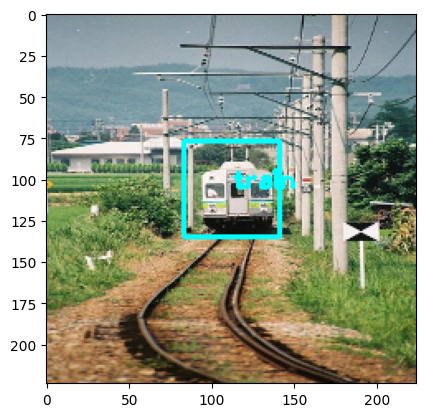

In [ ]:
from tqdm import tqdm

if CHOOSE == 'SINGLE':
    output_file = open('./test_prediction.txt', 'w')
    pbar = tqdm(test_dataset, total=len(test_dataset))

    for img_name, test_img, img_h, img_w in enumerate(pbar):
        batch_num = img_name.shape[0]
        for i in range(batch_num):
            xmin, ymin, xmax, ymax, class_num, conf = process_outputs_single(prediction_step(test_img[i:i+1]))
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

    output_file.close()

    np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000013.jpg')
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

    y_pred = YOLO(np_img, training=False)
    xmin, ymin, xmax, ymax, class_num, conf = process_outputs_single(y_pred)

    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, classes_name[class_num], (0, 200), 2, 1.5, (0, 255, 255), 2)

    plt.imshow(resized_img)
    plt.show()

else:
    output_file = open('./test_prediction.txt', 'w')
    pbar = tqdm(test_dataset, total=len(test_dataset))
    for img_name, test_img, img_h, img_w in pbar:
        batch_num = img_name.shape[0]
        img_h, img_w = tf.cast(img_h, tf.float32), tf.cast(img_w, tf.float32)
        for i in range(batch_num):
            xmin, ymin, xmax, ymax, class_num, conf = process_outputs_multi(prediction_step(test_img[i:i+1]))
            for j in range(len(xmin)):
                # print(xmin[j], ymin[j], xmax[j], ymax[j])
                # xmin[j], ymin[j], xmax[j], ymax[j] = xmin[j]*(img_w[i:i+1]/IMAGE_SIZE), ymin[j]*(img_h[i:i+1]/IMAGE_SIZE), xmax[j]*(img_w[i:i+1]/IMAGE_SIZE), ymax[j]*(img_h[i:i+1]/IMAGE_SIZE)
                # img filename, xmin, ymin, xmax, ymax, class, confidence
                output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin[j]*(img_w[i:i+1]/IMAGE_SIZE), 
                                                                                                      ymin[j]*(img_h[i:i+1]/IMAGE_SIZE), 
                                                                                                      xmax[j]*(img_w[i:i+1]/IMAGE_SIZE), 
                                                                                                      ymax[j]*(img_h[i:i+1]/IMAGE_SIZE), 
                                                                                                               class_num[j], 
                                                                                                               conf[j]))

    output_file.close()

    np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

    y_pred = YOLO(np_img, training=False)
    xmin, ymin, xmax, ymax, class_num, conf = process_outputs_multi(y_pred)

    for j in range(len(xmin)):
        cv2.rectangle(resized_img, (int(xmin[j]), int(ymin[j])), (int(xmax[j]), int(ymax[j])), (0, 255, 255), 2)
        cv2.putText(resized_img, classes_name[class_num[j]], (int((xmin[j] + xmax[j]) // 2) 
                                                              , int((ymin[j] + ymax[j]) // 2)), 1, 1, (0, 255, 255), 2)

    plt.imshow(resized_img)
    plt.show()

In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation


In [ ]:
import pandas as pd
cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

score: 0.335825


## Conclusion

在Model的選擇上，我們選用了包含Pyramid Network跟anchor技術的YOLOv7，透過Pyramid Network，我們可以針對大小不同的object去做更好的偵測；透過anchor，我們可以讓model去更好的學習predicted box。這讓我們知道，好的model設計可以在對應的題目上有著飛躍性的進步。

然而，由於替換Model的架構，導致我們Loss也需要跟著修改，由於TensorFlow為了優化會在code執行的過程中加上許多限制跟條件，因此在修改的過程中，我們花了很大的心力讓TensorFlow可以正確的計算loss，不過這也讓我們對於TensorFlow的設計有更多的理解。

另外，在選擇Backbone上，我們根據原文選擇了ConvNeXt作為feature extracter，而TensorFlow中又分別提供了Tiny、Small、Base跟Large等四個不同大小的版本，我們最後選用了Large的版本當Backbone，雖然效果變得相當不錯，不過這也讓我們單次epoch所需的時間以及總共所需的epochs數量大幅增加，這也讓我們了解到了計算資源對於Deep Learning的重要性。